<a href="https://colab.research.google.com/github/juan-cv/Detector-de-Fraudes/blob/main/detector_fraudes_tarjeta_credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de fraude con tarjetas de crédito.

Este kernel es mi intento de aprender los conceptos básicos de Machine Learning.

Es de gran importancia que las compañías de tarjetas de crédito puedan reconocer
transacciones fraudulentas con tarjeta de crédito, para que a los clientes no se les cobre por
artículos que no compraron. La base contiene transacciones realizadas con tarjetas de crédito en
septiembre de 2013 por tarjetahabientes europeos para analizar transacciones
fraudulento.


### Index 
1. Importando bibliotecas e dados
2. Explorar dados
3. Reamostrar dados
4. Prepare o conjunto de dados de treinamento e teste
5. Aplique diferentes classificadores

## 1. Importando bibliotecas e dados

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

In [ ]:
data = pd.read_csv("../input/creditcardfraud/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



# 2. Explorar os dados

In [ ]:
number_of_fraud = len(data[data.Class == 1])
number_of_normal= len(data[data.Class == 0])

print ("Fraude:", number_of_fraud)
print ("Normal:",number_of_normal)

Fraude: 492
Normal: 284315


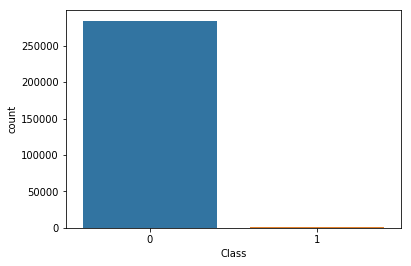

In [ ]:
sns.countplot("Class",data=data)

# Explorar recursos

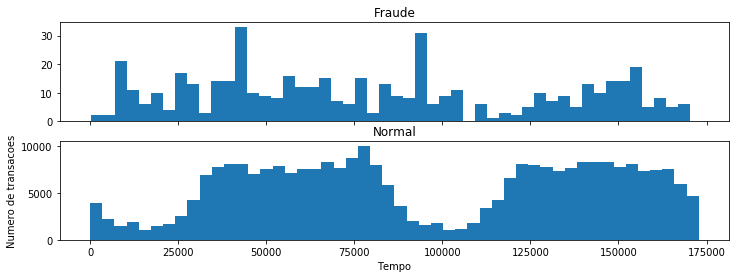

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
bins = 50

ax1.hist(data.Time[data.Class == 1], bins = bins)
ax1.set_title('Fraude')

ax2.hist(data.Time[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Tempo')
plt.ylabel('Numero de transacoes')
plt.show()


Parece que as transações fraudulentas são distribuídas de maneira mais uniforme, enquanto as transações normais têm uma distribuição cíclica. Vamos olhar a quantidade.

In [ ]:
print ("Fraude")
print (data.Amount[data.Class == 1].describe())
print ()
print ("Normal")
print (data.Amount[data.Class == 0].describe())

Fraude
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


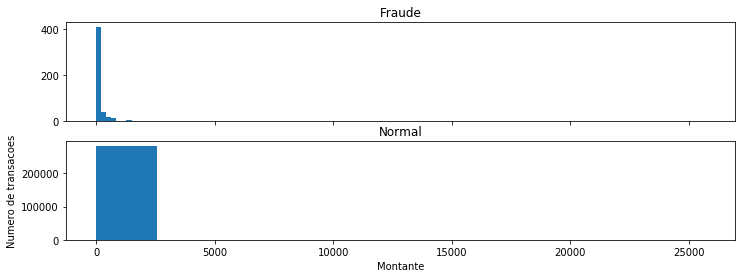

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
bins = 10

ax1.hist(data.Amount[data.Class == 1], bins = bins)
ax1.set_title('Fraude')

ax2.hist(data.Amount[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Montante')
plt.ylabel('Numero de transacoes')
plt.show()

Ahora veamos las características generadas por PCA, cómo cada característica se correlaciona con la clase.

PCA (es un procedimiento matemático que utiliza una transformación ortogonal (ortogonalización de vectores) para convertir un conjunto de observaciones de variables posiblemente correlacionadas en un conjunto de valores de variables linealmente no correlacionadas llamados componentes principales).

In [ ]:
PCA_features = data.iloc[:,1:29].columns

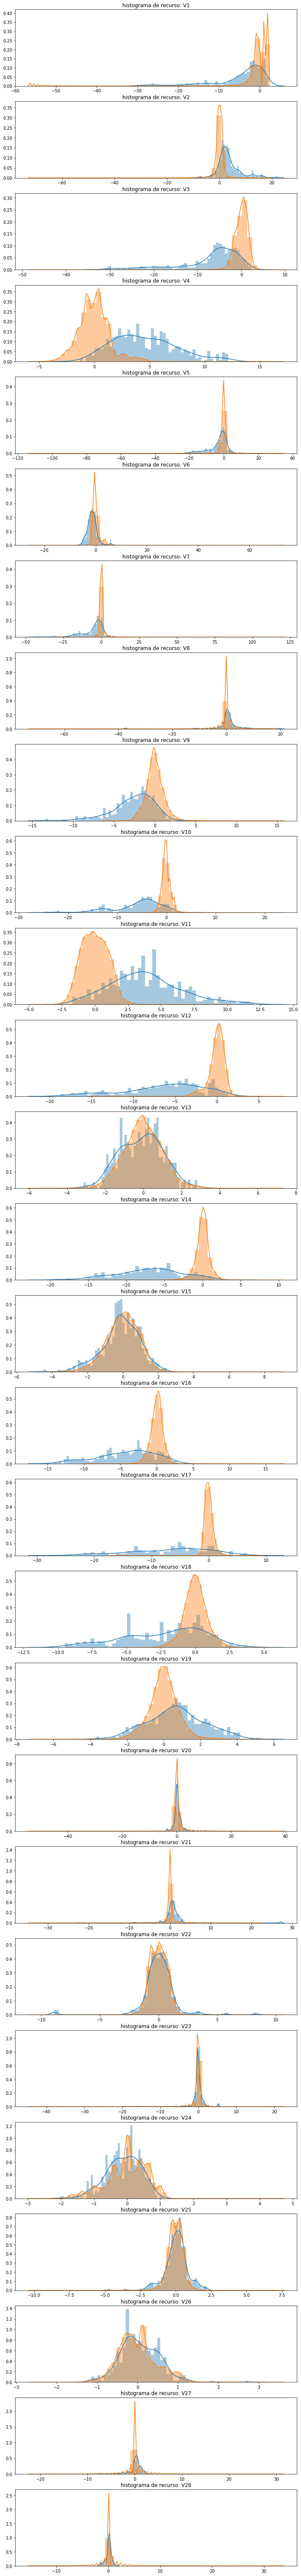

In [ ]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(data[PCA_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[cn][data.Class == 1], bins=50)
    sns.distplot(data[cn][data.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histograma de recurso: ' + str(cn))
plt.show()

* Parece que para v8, v13, v15, v20, v23, v24, v25, v26, v27, v28 tienen una distribución similar entre los dos tipos de transacciones. Para la selección de características podemos descartar estas características.

In [ ]:
data = data.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,69.99,0



Escala de recursos

In [ ]:
data['Normalized_Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,...,V12,V14,V16,V17,V18,V19,V21,Amount,Class,Normalized_Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,...,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,149.62,0,0.244964
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,...,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,2.69,0,-0.342475
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,...,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,378.66,0,1.160686
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,...,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,123.50,0,0.140534
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,...,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,69.99,0,-0.073403


In [ ]:
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Class,Normalized_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,0,-0.073403



Claramente, os dados estão totalmente desequilibrados!
Abordagens:
1. reamostrar dados (subamostragem / superamostragem) e, em seguida, aplicar diferentes classificadores
2. logística de Regressão
3. SVM


# # 3. Datos de remuestreo


Subamostragem: com base na proporção 50/50, escolha aleatoriamente amostras da classe normal

In [ ]:
#índices of normal class
indices_of_normal = data[data.Class==0].index
#escolha aleatoriamente a mesma quantidade de amostras que a fraude e retorne seus índices
random_indices_of_normal = np.array(np.random.choice(indices_of_normal, number_of_fraud, replace=False))
#indices of fraud class
indices_of_fraud = np.array(data[data.Class == 1].index)
#indices of undersampled dataset
indices_of_undersampled = np.concatenate([random_indices_of_normal, indices_of_fraud])
#conjunto de dados com pouca amostra
data_of_undersampled = data.iloc[indices_of_undersampled,:]

print(len(data_of_undersampled))

984



# 4. Prepare o conjunto de dados de treinamento e teste

In [ ]:
#conjunto de dados inteiro
X = data.loc[:,data.columns!='Class']
y = data.loc[:,data.columns=='Class']

#treinar e testar o conjunto de dados dividido em todo o conjunto de dados, com proporção 70/30
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Numero de transacoes treinar conjunto de dados: ", len(X_train))
print("Conjunto de dados de teste de transacoes numericas: ", len(X_test))
print("Numero total de transacoes: ", len(X_train)+len(X_test))

Numero de transacoes treinar conjunto de dados:  199364
Conjunto de dados de teste de transacoes numericas:  85443
Numero total de transacoes:  284807


In [ ]:
#conjunto de dados com pouca amostra
X_undersampled = data_of_undersampled.loc[:,data_of_undersampled.columns!='Class']
y_undersampled = data_of_undersampled.loc[:,data_of_undersampled.columns=='Class']

#conjunto de dados de trem e teste dividido a partir de um conjunto de dados com pouca amostra, com razão 70/30
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled,y_undersampled,test_size = 0.3, random_state = 0)

print("Numero de transacoes treinar conjunto de dados: ", len(X_train_undersampled))
print("Conjunto de dados de teste de transacoes numericas: ", len(X_test_undersampled))
print("Numero total de transacoes: ", len(X_train_undersampled)+len(X_test_undersampled))

Numero de transacoes treinar conjunto de dados:  688
Conjunto de dados de teste de transacoes numericas:  296
Numero total de transacoes:  984



# 5. Aplique diferentes classificadores

Defina una función para entrenar datos con diferentes clasificadores con validación cruzada K-Fold para obtener el mejor parámetro C.

(El método de validación cruzada llamado k-fold consiste en dividir el conjunto de datos total en k subconjuntos mutuamente excluyentes del mismo tamaño y, a partir de ahí, un subconjunto se utiliza para la prueba y los k-1 restantes se utilizan para la estimación de parámetros, calculando el precisión del modelo. Este proceso se realiza k veces alternando el subconjunto de prueba de forma circular).

In [ ]:
def train(model,X,y):
    
    # Recordar para o modelo
    clf = model
    
    # Diferentes parâmetros C para regularização
    C_param = [0.01,0.1,1,10,100]

    # Validação cruzada do K-Fold
    kf = KFold(n_splits=5)
    
    # Inicializacao
    scores     =[]
    best_score = 0
    best_C     = 0
    
    for C in C_param:
        
        clf.C = C

        score = []
        for train_index, test_index in kf.split(X): 

            # Use os dados de treinamento divididos para ajustar-se ao modelo.
            clf.fit(X.iloc[train_index,:].values,y.iloc[train_index,:].values.ravel())

            # Prever valores usando os dados de teste divididos
            y_pred = clf.predict(X.iloc[test_index,:].values)
            
            # Calcular a pontuação de rechamada e anexá-la a uma lista de pontuações de rechamada representando o parâmetro c_ atual
            rec = recall_score(y.iloc[test_index,:].values.ravel(),y_pred)
            
            # Anexar pontuação de recordar de cada iteração à pontuação
            score.append(rec)

        # Calcule a pontuação média real para todas as iterações e compare-a com a melhor pontuação.
        mean_score = np.mean(score)
        if mean_score > best_score:
            best_score = mean_score
            best_C     = C
        
        # Anexar a pontuação média de cada C às pontuações
        scores.append(np.mean(score))
        
    # Crie um quadro de dados para mostrar a pontuação média para cada parâmetro C    
    lr_results = pd.DataFrame({'Pontuacao':scores, 'C':C_param}) 
    print(lr_results)
    
    print("A melhor pontuacao de recordacao eh: ", best_score)
    print("O melhor parametro C eh: ", best_C)
    
    return best_score, best_C

Definir uma função para usar o melhor parâmetro C para treinar em diferentes conjuntos de dados de treinamento e prever em diferentes conjuntos de dados de teste; Plote confusion_matrix (existe uma função oficial para plotar matriz de confusão no sklearn: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) e imprima o relatório de classificação.

In [ ]:
def predict(model, X_train, y_train, X_test, y_test):
    # Recordar para o modelo
    clf = model
    #clf = Regressão logística (C = C, penalidade = 'l1')
    # Use todo o conjunto de dados de trem com pouca amostra para ajustar-se ao modelo.
    clf.fit(X_train.values,y_train.values.ravel())
    # Previsão no conjunto de dados de teste com pouca amostra

    y_pred = clf.predict(X_test.values)

    # Matriz de confusão
    CM = confusion_matrix(y_test.values, y_pred)
    # Obter verdadeiros positivos (tp), falsos positivos (fp), falsos negativos (fn)
    tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

    # Prediction report
    sns.heatmap(CM,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Matriz_de_confusao")
    plt.xlabel("Classe_prevista")
    plt.ylabel("Classe Real")
    plt.show()
    print("\n----------Relatorio de classificacao------------------------------------")
    print(classification_report(y_test.values, y_pred))

# logística de Regressão

Primero, entrene datos de bajo muestreo con el modelo de regresión logística + validación cruzada K-Fold para obtener el mejor parámetro C

(El modelo de regresión logística es similar al modelo de regresión lineal. Sin embargo, en el modelo logístico la variable de respuesta Y_i es binaria. Una variable binaria toma dos valores, por ejemplo, Y_i=0 y Y_i=1, llamados "fracaso" y " éxito", respectivamente).

In [ ]:
clf = LogisticRegression(penalty = 'l2', solver ='lbfgs')
best_score, best_C = train(clf, X_train_undersampled,y_train_undersampled)

   Pontuacao       C
0   0.880540    0.01
1   0.900566    0.10
2   0.905914    1.00
3   0.908731   10.00
4   0.911808  100.00
A melhor pontuacao de recordacao eh:  0.9118080809861876
O melhor parametro C eh:  100



En segundo lugar, entrenar con todo el conjunto de datos de tren de muestra baja y predecir con el conjunto de datos de prueba de muestra baja.

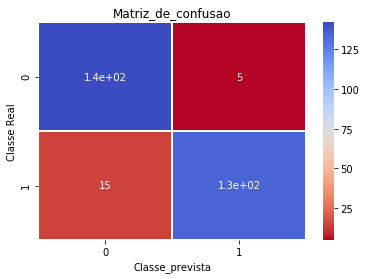


----------Relatorio de classificacao------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       147
           1       0.96      0.90      0.93       149

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296



In [ ]:
clf = LogisticRegression(C=best_C, penalty = 'l2', solver ='lbfgs')
predict(clf, X_train_undersampled,y_train_undersampled,X_test_undersampled,y_test_undersampled)

De la matriz de confusión, podemos ver que solo 12 de 149 muestras de fraude no se predijeron correctamente. Y el modelo logró una precisión de recuperación del 93 %. Eso es bastante bueno, probemos el modelo para predecir todo el conjunto de datos de prueba en lugar del conjunto de datos de prueba submuestreado.

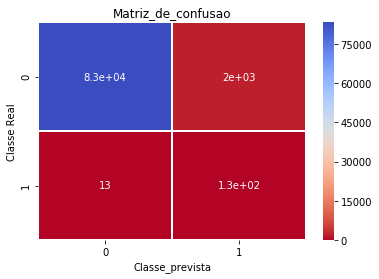


----------Relatorio de classificacao------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85296
           1       0.06      0.91      0.12       147

    accuracy                           0.98     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.98      0.99     85443



In [ ]:
predict(clf,X_train_undersampled,y_train_undersampled,X_test,y_test)

La precisión de recuperación es aproximadamente la misma (11 de 147) que la predicha en el conjunto de datos de prueba de muestra baja. Entonces parece que el modelo funciona bien con submuestreo. Entonces, ¿qué tal aplicar el mismo modelo en todos los conjuntos de datos sin volver a muestrear? Entrenaremos todo el conjunto de datos con el mismo modelo de regresión logística con validación cruzada y regularización K-Fold para obtener el mejor parámetro C, luego usaremos este parámetro para entrenar y predecir todo el tren y el conjunto de datos de prueba.

In [ ]:
clf = LogisticRegression(penalty = 'l2',solver ='lbfgs')
best_score_whole, best_C_whole = train(clf,X_train,y_train)

   Pontuacao       C
0   0.584432    0.01
1   0.604700    0.10
2   0.608022    1.00
3   0.608022   10.00
4   0.608022  100.00
A melhor pontuacao de recordacao eh:  0.6080222307849583
O melhor parametro C eh:  1


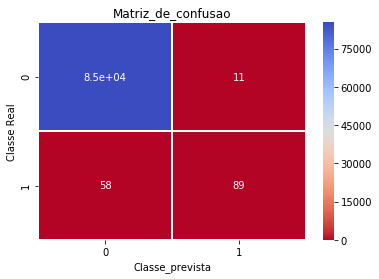


----------Relatorio de classificacao------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.89      0.61      0.72       147

    accuracy                           1.00     85443
   macro avg       0.94      0.80      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
clf = LogisticRegression(C=best_C_whole,penalty = 'l2',solver='lbfgs')
predict(clf,X_train,y_train,X_test,y_test)

En este caso, podemos ver que 58 de 147 fraudes no se predijeron correctamente. Por lo tanto, es obvio que al reducir la muestra de los datos hemos mejorado la recuperación del 61 % al 93 %. El submuestreo con regresión logística funciona muy bien para este problema. Entonces, ¿qué pasa con otros clasificadores? ¿Cómo mejoramos aún más la precisión de los pronósticos?

# SVM

SVM (Uma máquina de vetores de suporte é um conceito na ciência da computação para um conjunto de métodos do aprendizado supervisionado que analisam os dados e reconhecem padrões, usado para classificação e análise de regressão. O SVM padrão toma como entrada um conjunto de dados e prediz, para cada entrada dada, qual de duas possíveis classes a entrada faz parte, o que faz do SVM um classificador linear binário não probabilístico.

Probemos el mismo proceso que la regresión logística. Primero ajuste el modelo en el conjunto de datos de muestra baja, pronostique el conjunto de datos de prueba de muestra baja y todo el conjunto de datos de prueba, luego ajuste el modelo en todo el conjunto de datos y pronostique todo el conjunto de datos de prueba.

In [ ]:
clf = SVC(gamma='auto')
best_score, best_C = train(clf, X_train_undersampled,y_train_undersampled)

   Pontuacao       C
0   0.602817    0.01
1   0.917254    0.10
2   0.917254    1.00
3   0.921209   10.00
4   0.930277  100.00
A melhor pontuacao de recordacao eh:  0.9302774039019359
O melhor parametro C eh:  100


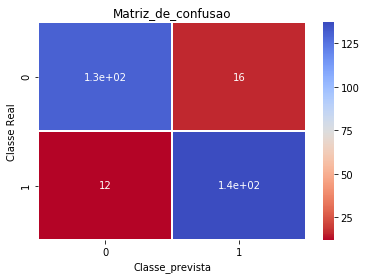


----------Relatorio de classificacao------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       147
           1       0.90      0.92      0.91       149

    accuracy                           0.91       296
   macro avg       0.91      0.91      0.91       296
weighted avg       0.91      0.91      0.91       296



In [ ]:
clf = SVC(C=best_C,gamma='auto')
predict(clf, X_train_undersampled,y_train_undersampled,X_test_undersampled,y_test_undersampled)

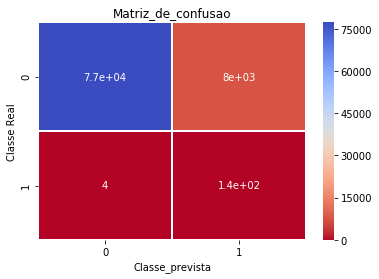


----------Relatorio de classificacao------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     85296
           1       0.02      0.97      0.03       147

    accuracy                           0.91     85443
   macro avg       0.51      0.94      0.49     85443
weighted avg       1.00      0.91      0.95     85443



In [ ]:
predict(clf,X_train_undersampled,y_train_undersampled,X_test,y_test)

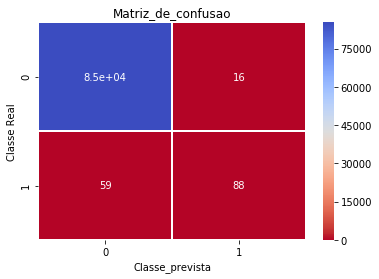


----------Relatorio de classificacao------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.85      0.60      0.70       147

    accuracy                           1.00     85443
   macro avg       0.92      0.80      0.85     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
predict(clf,X_train,y_train,X_test,y_test)